## Cartpole Challenge

Trying a fully connected neural net for the cart pole challenge. I am curious if current data is enough to perform well enough or if this is a problem where an RNN would be a better choice.

In [1]:
import time
import gym
import random
import numpy as np
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import mean, median
from collections import Counter
import tensorflow as tf
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
env = gym.make('CartPole-v0')
env.reset()

sess = tf.Session()
#sess = tf.InteractiveSession()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Create random training Data
Create random training data. Keep above avarage performing examples.

In [3]:
def flatten_game_data(games):
    if len(games) > 0:
        training_data_by_game = list(map( (lambda game: game[1]), games))
        flat_training_data = reduce(lambda x,y: x+y, training_data_by_game)
        return flat_training_data

def append_to_file(flat_games):
    print("type ", type(flat_games), "len ", len(flat_games))
    if np.DataSource().exists('max_scoring_games.npy'):
        all_max_games = np.load('max_scoring_games.npy') 
    else:
        all_max_games = [] 
    all_max_games = np.append(all_max_games, flat_games)
    print("type ", type(all_max_games), "len ", len(all_max_games))
    np.save('max_scoring_games.npy', all_max_games)       
    
def create_training_data(n_games=100, percentile_threshold=75, model=False):
    games = []
    for iteration in tqdm(range(n_games), mininterval=2, desc="create_training_data n_games"):

        score = 0
        game_data = []
        prev_observation = env.reset()
        while True:
            
            if(model):
                tflearn.is_training(False, sess)
                action = np.argmax(model.predict(prev_observation.reshape(-1, len(prev_observation), 1)) [0])
            else:
                action = random.randrange(0,2)
                
            observation, reward, done, info = env.step(action)
            
            action_one_hot = [0,1] if (action == 1) else [1,0]
            game_data.append([prev_observation, action_one_hot])
            
            prev_observation = observation
            
            deviation_from_center = np.absolute(observation[0])
            score += reward - deviation_from_center
            
            if done:
                break
        games.append([score, game_data])
        
    scores = list(map(lambda game: game[0], games))
    score_threshold = np.percentile( scores , percentile_threshold)

    games = list(filter( (lambda game: game[0]>=score_threshold), games))
    flat_training_data = flatten_game_data(games)
    
    plt.hist(scores, bins=30)
    plt.title('Scores for random training data')
    plt.axvline(x=score_threshold, color='r')
    plt.text(score_threshold,-1,'threshold',rotation=90)

    # special case for max scoring games ... theoretical max score is 200 but I added a penalty for diverging from the center of the playing field so ...
    max_score = 195
    max_games = list(filter( (lambda game: game[0]>=max_score), games))
    if(len(max_games) > 0):
        append_to_file(flatten_game_data(max_games))    
    
    return flat_training_data


Executing this should result in a decent training set.

create_training_data n_games: 100%|██████████| 100/100 [00:00<00:00, 2785.36it/s]


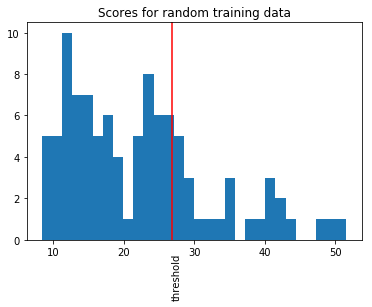

In [4]:
random_training_data = create_training_data(n_games=100, percentile_threshold=75)

# Create the model

In [10]:
def create_model(learning_rate=1e-3):
    print("Creating model")
    
    input_size = 4
    network = input_data(shape = [None, input_size, 1], name='input')
    
    network = fully_connected(network, 32, activation='relu')
    #network = dropout(network, 0.8)

    network = fully_connected(network, 32, activation='relu')
    #network = dropout(network, 0.8)

    network = fully_connected(network, 32, activation='relu')
    #network = dropout(network, 0.8)

    output_size = 2
    network = fully_connected(network, output_size, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=learning_rate, loss = 'categorical_crossentropy', name='targets')

    model = tflearn.DNN(network, tensorboard_dir='log')
    return model

In [11]:
def train_model(training_data, model=False, n_epoch=1):
    tflearn.is_training(True, sess)
    
    #print("Reshaping array with shape ", training_data.shape)
    dim_x = len(training_data[0][0])
    #dim_x = "?"
    dim_y = len(training_data[0][1])
    #dim_y = "?"
    m = len(training_data)
    print("Reshaping array with shape ", m, len(training_data[0]), dim_x, dim_y, "typeX", type(training_data[0][0][0]))
    X = np.array([i[0] for i in training_data]).reshape(-1, len(training_data[0][0]), 1)
    Y = [i[1] for i in training_data]
    print("shape x", X.shape)
    print("shepe y", len(Y), len(Y[0]))

    if not model:
        model = create_model()
    
    print("Training model")
    model.fit({'input':X}, {'targets':Y}, n_epoch=n_epoch, snapshot_step=500, show_metric=True,
                run_id='fit'+str(int(time.time())))

    return model

In [7]:
model = create_model(learning_rate=1e-3)

Creating model
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Training Step: 144  | total loss: 0.69094 | time: 1.212s
| Adam | epoch: 001 | loss: 0.69094 - acc: 0.5477 -- iter: 9216/9250
Training Step: 145  | total loss: 0.69089 | time: 1.218s
| Adam | epoch: 001 | loss: 0.69089 - acc: 0.5398 -- iter: 9250/9250
--


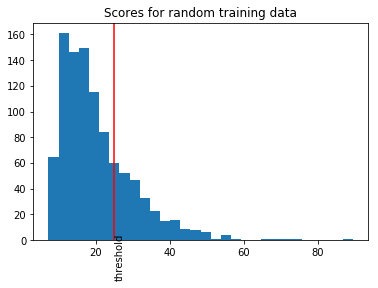

In [8]:
random_training_data = create_training_data(n_games=1000, percentile_threshold=75)
model = train_model(random_training_data, model)

The ADAM optimizer is not able to achieve accuracies over 60% which makes sense since we fed it mostly random data.
On next iterations the DNN should be able to reproduce the results of all runs with a score above the 75 percentile.

Training Step: 2307  | total loss: 0.02251 | time: 4.721s
| Adam | epoch: 004 | loss: 0.02251 - acc: 0.9897 -- iter: 46144/46177
Training Step: 2308  | total loss: 0.02461 | time: 4.732s
| Adam | epoch: 004 | loss: 0.02461 - acc: 0.9876 -- iter: 46177/46177
--


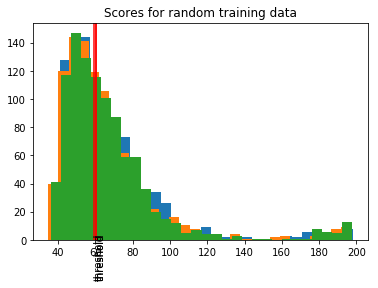

In [9]:
for _ in range(3):
    training_data = create_training_data(n_games=1000, percentile_threshold=50, model=model)
    model = train_model(training_data, model)

Two strange results:
* The model performs significantly better than the training data. I would have expected results close to the 75 percentile of the first attempt, which should have scored around 30 and 40 and not around 180.
* Feeding the net further with the best attempts of previous runs does not improve the model. I seem to have hit a wall here.

Interpretation:
* 99% accuracy means I'm able to fit the training data. So I'd say there are no bias problems. 
* The model is not able to score well on test time which I'd interpret as a variance problem. 
 * More training data. Maybe put all 200 scoring runs into a bucket and train on them instead of X percentile of previous runs.
 * Regularization techniques like dropout and L2
* Model size seems to be sufficient at first glance. Otherwise it wouldnt be able to fit so well. Maybe introducing dropout will force me to increase my model size.
* I will not yet succumb to the call of RNN ;)

In [12]:
# I got the dimensions really wonky in the beginning so I have to do some serious fixing here
def load_training_data():    
    print("Loading file")
    if np.DataSource().exists('max_scoring_games.npy'):
        data= np.load('max_scoring_games.npy')
        data = data.reshape(int(len(data)/2),2)
        data = [  [i[0], i[1]]  for i in data]
        return data
    else:
        return []

def load_and_merge_training_data(training_data):
    all_max_games = load_training_data()
    print('using ', len(all_max_games), ' max scoring moves from previous runs to train the net')
    
    #print(training_data[0], len(training_data), type(training_data))
    #print("yyyyyyyyyyyyyyyyyyyyyyyy")
    #print(all_max_games[0], len(all_max_games), type(all_max_games))
    #print("yyyyyyyyyyyyyyyyyyyyyyyy")

    training_data = np.append(training_data, all_max_games)
    training_data = training_data.reshape(int( len(training_data)/2),2)
    training_data = [  [i[0], i[1]]  for i in training_data]

    
    #print(training_data[0], training_data[1], len(training_data), type(training_data))
    
    return training_data

Now do the same but add more data by using all previously achieved max scoring games. Successively calling these lines should result in a growing file with perfect scores.

Training Step: 15587  | total loss: 0.14937 | time: 15.477s
| Adam | epoch: 010 | loss: 0.14937 - acc: 0.9568 -- iter: 167360/167400
Training Step: 15588  | total loss: 0.14953 | time: 15.482s
| Adam | epoch: 010 | loss: 0.14953 - acc: 0.9564 -- iter: 167400/167400
--


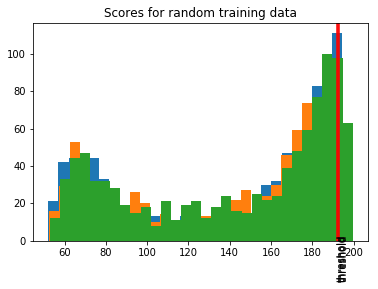

In [14]:
for _ in range(3):
    training_data = create_training_data(n_games=1000, percentile_threshold=90, model=model)
    training_data = load_and_merge_training_data(training_data)
    model = train_model(training_data, model)

More data really helped. After 6 epochs the NN has gradually improved. 